## March Machine Learning Mania 2021 - NCAAM


![banner](https://storage.googleapis.com/kaggle-competitions/kaggle/26080/logos/header.png?t=2021-02-24-01-37-37)

**What we need to predict**

**Stage 1** - We submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (2015-2019).

**Stage 2** - We submit predicted probabilities for every possible matchup before the 2021 tournament begins.

**This notebook is inspired from the data description page of the comp. Data column decriptions are directly taken from
there. In the Notebook I explores the csv files and the description is there for reference**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ncaam-march-mania-2021/Conferences.csv
/kaggle/input/ncaam-march-mania-2021/MNCAATourneySeedRoundSlots.csv
/kaggle/input/ncaam-march-mania-2021/MRegularSeasonDetailedResults.csv
/kaggle/input/ncaam-march-mania-2021/MNCAATourneyCompactResults.csv
/kaggle/input/ncaam-march-mania-2021/MGameCities.csv
/kaggle/input/ncaam-march-mania-2021/MSeasons.csv
/kaggle/input/ncaam-march-mania-2021/MSecondaryTourneyTeams.csv
/kaggle/input/ncaam-march-mania-2021/Cities.csv
/kaggle/input/ncaam-march-mania-2021/MTeamSpellings.csv
/kaggle/input/ncaam-march-mania-2021/MRegularSeasonCompactResults.csv
/kaggle/input/ncaam-march-mania-2021/MMasseyOrdinals.csv
/kaggle/input/ncaam-march-mania-2021/MSecondaryTourneyCompactResults.csv
/kaggle/input/ncaam-march-mania-2021/MNCAATourneySlots.csv
/kaggle/input/ncaam-march-mania-2021/MNCAATourneySeeds.csv
/kaggle/input/ncaam-march-mania-2021/MTeamCoaches.csv
/kaggle/input/ncaam-march-mania-2021/MConferenceTourneyGames.csv
/kaggle/input/ncaam-march-mania-

# The Basics

**This section provides everything you need to build a simple prediction model and submit predictions.**

### Teams.csv

This file identifies the different college teams present in the dataset. Each school is uniquely identified by a 4 digit id number. You will not see games present for all teams in all seasons, because the games listing is only for matchups where both teams are Division-I teams. There are 357 teams currently in Division-I, and an overall total of 371 teams in our team listing (each year, some teams might start being Division-I programs, and others might stop being Division-I programs). This year there are four teams that are new to Division I: Bellarmine (TeamID=1469), North Alabama (TeamID=1469), Tarleton State (TeamID=1470), and UC_San Diego (TeamID=1471) and so you will not see any historical data for these teams prior to the current season. In addition, some teams opted not to play during the 2021 season due to the impact of COVID-19 and will not have any games listed.

* **TeamID** - a 4 digit id number, from 1000-1999, uniquely identifying each NCAA® men's team. A school's TeamID does not change from one year to the next, so for instance the Duke men's TeamID is 1181 for all seasons. To avoid possible confusion between the men's data and the women's data, all of the men's team ID's range from 1000-1999, whereas all of the women's team ID's range from 3000-3999.

* **TeamName** - a compact spelling of the team's college name, 16 characters or fewer. There are no commas or double-quotes in the team names, but you will see some characters that are not letters or spaces, e.g., Texas A&M, St Mary's CA, TAM C. Christi, and Bethune-Cookman.

* **FirstD1Season** - the first season in our dataset that the school was a Division-I school. For instance, FL Gulf Coast (famously) was not a Division-I school until the 2008 season, despite their two wins just five years later in the 2013 NCAA® tourney. Of course, many schools were Division-I far earlier than 1985, but since we don't have any data included prior to 1985, all such teams are listed with a FirstD1Season of 1985.

* **LastD1Season** - the last season in our dataset that the school was a Division-I school. For any teams that are currently Division-I, they will be listed with LastD1Season=2021, and you can confirm there are 357 such teams.


In [2]:
teams = pd.read_csv("/kaggle/input/ncaam-march-mania-2021/MTeams.csv")
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021


In [3]:
teams.shape

(371, 4)

In [4]:
len(teams.TeamID.unique())

371

In [5]:
len(teams.TeamName.unique())

371

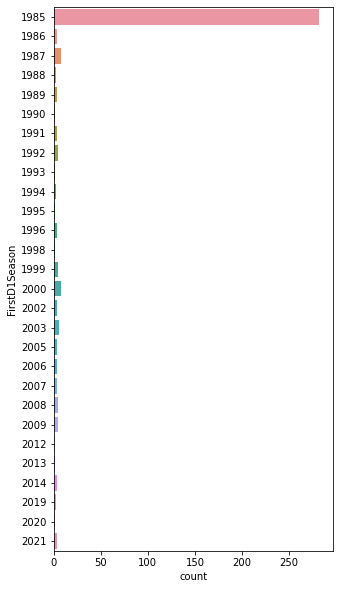

In [6]:
fig = plt.figure(figsize=(5, 10))
sns.countplot(data=teams, y='FirstD1Season');
plt.show()

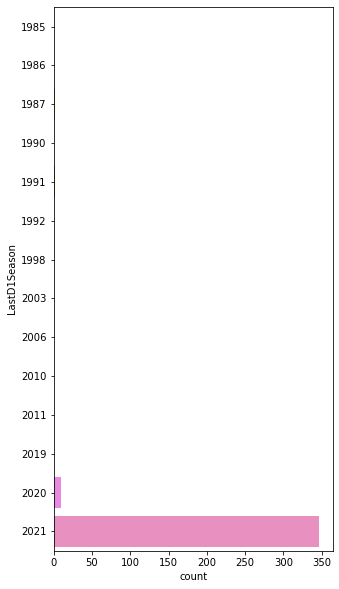

In [7]:
fig = plt.figure(figsize=(5, 10))
sns.countplot(data=teams, y='LastD1Season');
plt.show()

## MSeasons.csv

This file identifies the different seasons included in the historical data, along with certain season-level properties.
* **Season** - indicates the year in which the tournament was played. Remember that the current season counts as 2021.

* **DayZero** - tells you the date corresponding to DayNum=0 during that season. All game dates have been aligned upon a common scale so that (each year) the Monday championship game of the men's tournament is on DayNum=154. Working backward, the national semifinals are always on DayNum=152, the "play-in" games are on days 135, Selection Sunday is on day 132, the final day of the regular season is also day 132, and so on. All game data includes the day number in order to make it easier to perform date calculations. If you need to know the exact date a game was played on, you can combine the game's "DayNum" with the season's "DayZero". For instance, since day zero during the 2011-2012 season was 10/31/2011, if we know that the earliest regular season games that year were played on DayNum=7, they were therefore played on 11/07/2011.
   
* **RegionW, RegionX, Region Y, Region Z** - by our contests' convention, each of the four regions in the final tournament is assigned a letter of W, X, Y, or Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files, even if the region names change from year to year. For instance, during the 2012 tournament, the four regions were East, Midwest, South, and West. Being the first alphabetically, East becomes W. Since the East regional champion (Ohio State) played against the Midwest regional champion (Kansas) in the national semifinals, that makes Midwest be region X. For the other two (South and West), since South comes first alphabetically, that makes South Y and therefore West is Z. So for that season, the W/X/Y/Z are East,Midwest,South,West. And so for instance, Ohio State, the #2 seed in the East, is listed in the MNCAATourneySeeds file that year with a seed of W02, meaning they were the #2 seed in the W region (the East region). We will not know the final W/X/Y/Z designations until Selection Sunday, because the national semifinal pairings in the Final Four will depend upon the overall ranks of the four #1 seeds.


In [8]:
seasons = pd.read_csv("/kaggle/input/ncaam-march-mania-2021/MSeasons.csv")
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [9]:
seasons.shape

(37, 6)

In [10]:
len(seasons.Season.unique())

37

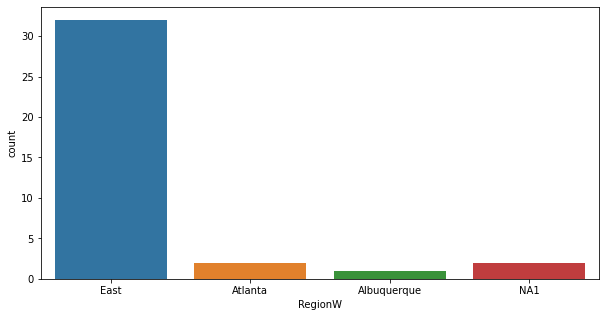

In [11]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=seasons, x='RegionW');
plt.show()

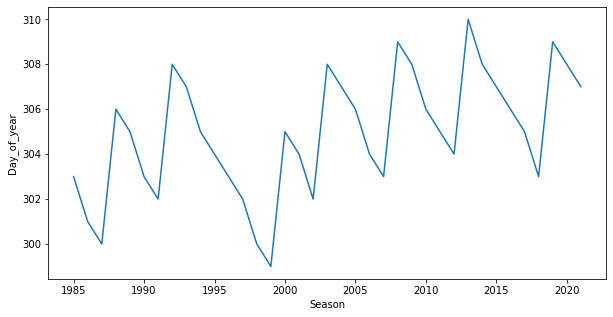

In [12]:
seasons["Day_of_year"] = pd.to_datetime(seasons["DayZero"]).apply(lambda x: x.day_of_year)
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x=seasons.Season, y=seasons.Day_of_year);
plt.show()

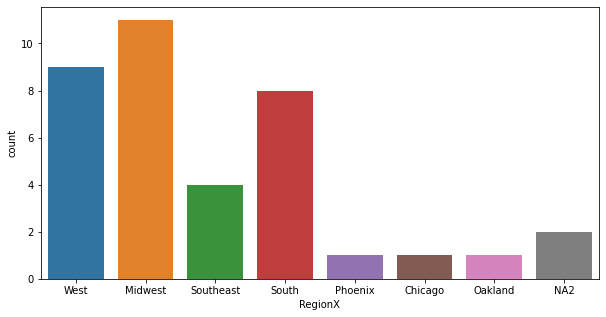

In [13]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=seasons, x='RegionX');
plt.show()

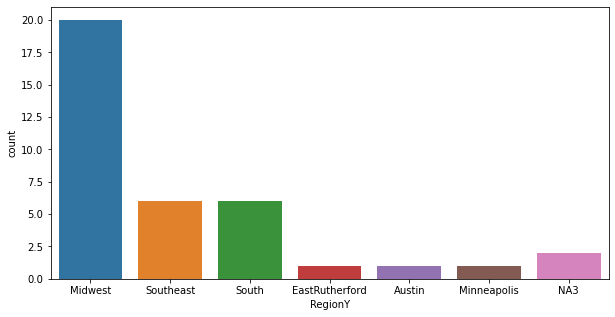

In [14]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=seasons, x='RegionY');
plt.show()

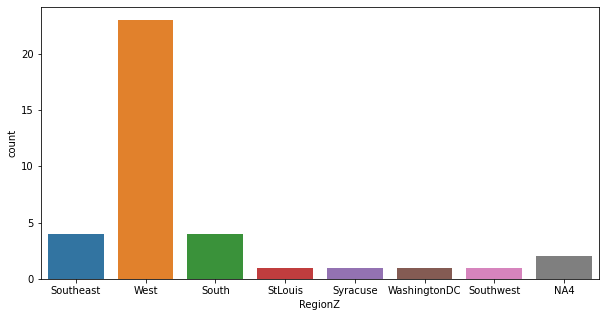

In [15]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=seasons, x='RegionZ');
plt.show()

## MNCAATourneySeeds.csv

this file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 14, 2021 (DayNum=132).
* **Season** - the year that the tournament was played in

* **Seed** - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have seeds with the same first three characters. The "a" and "b" are assigned based on which Team ID is lower numerically. As an example of the format of the seed, the first record in the file is seed W01 from 1985, which means we are looking at the #1 seed in the W region (which we can see from the "MSeasons.csv" file was the East region).

* **TeamID** - this identifies the id number of the team, as specified in the MTeams.csv file


In [16]:
MNCAATourneySeeds =  pd.read_csv("../input/ncaam-march-mania-2021/MNCAATourneySeeds.csv")
MNCAATourneySeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [17]:
MNCAATourneySeeds.tail()

,Season,Seed,TeamID
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159
2285,2019,Z16,1205


In [18]:
MNCAATourneySeeds.shape

(2286, 3)

In [19]:
len(MNCAATourneySeeds.Season.unique())

35

In [20]:
len(MNCAATourneySeeds.Seed.unique())

90

In [21]:
len(MNCAATourneySeeds.TeamID.unique())

300

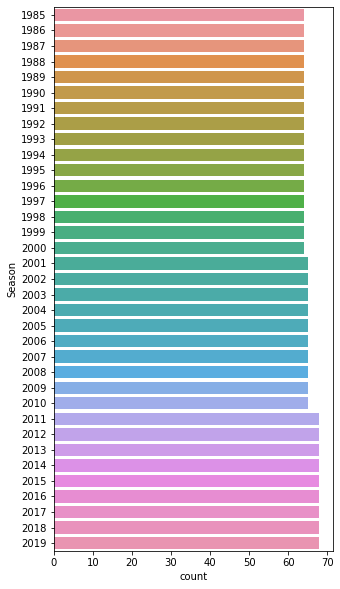

In [22]:
fig = plt.figure(figsize=(5, 10))
sns.countplot(data=MNCAATourneySeeds, y='Season');
plt.show()

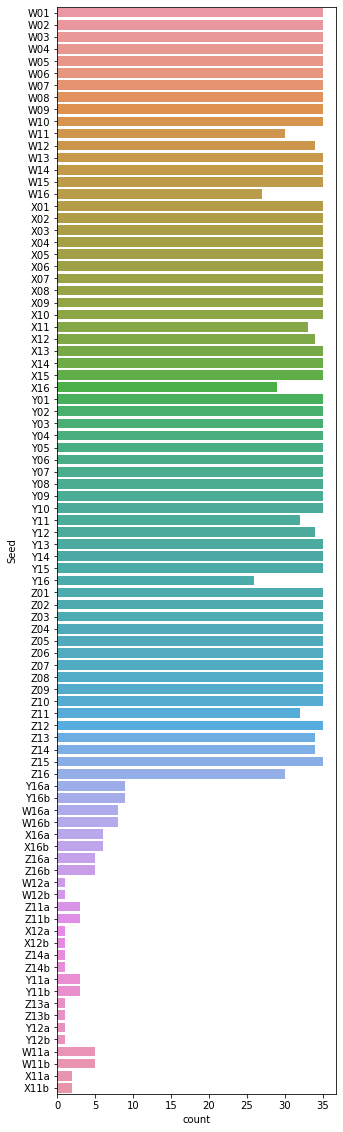

In [23]:
fig = plt.figure(figsize=(5, 20))
sns.countplot(data=MNCAATourneySeeds, y='Seed');
plt.show()

## MRegularSeasonCompactResults.csv

This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

* **Season** - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs). For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.

* **DayNum** - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "MSeasons.csv" file. For example, the first game in the file was DayNum=20. Combined with the fact from the "MSeasons.csv" file that day zero was 10/29/1984 that year, this means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID). In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day because of a tornado, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original scheduled date.

* **WTeamID** - this identifies the id number of the team that won the game, as listed in the "MTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.

* **WScore** - this identifies the number of points scored by the winning team.

* **LTeamID** - this identifies the id number of the team that lost the game.

* **LScore** - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.

* **WLoc** - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.

* **NumOT** - this indicates the number of overtime periods in the game, an integer 0 or higher.


In [24]:
MRegularSeasonCompactResults = pd.read_csv("../input/ncaam-march-mania-2021/MRegularSeasonCompactResults.csv")
MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [25]:
MRegularSeasonCompactResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
166875,2020,128,1204,81,1209,62,A,0
166876,2020,128,1402,85,1111,68,H,0
166877,2020,128,1299,86,1224,77,N,0
166878,2020,128,1393,81,1314,53,N,0
166879,2020,128,1389,56,1233,54,N,0


In [26]:
MRegularSeasonCompactResults.shape

(166880, 8)

In [27]:
MRegularSeasonCompactResults.Season.value_counts()

2019    5463
2018    5405
2017    5395
2016    5369
2014    5362
2015    5354
2020    5328
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
2002    4555
2000    4519
2001    4467
1999    4222
1998    4167
1997    4155
1992    4127
1991    4123
1996    4122
1995    4077
1994    4060
1990    4045
1989    4037
1993    3982
1988    3955
1987    3915
1986    3783
1985    3737
Name: Season, dtype: int64

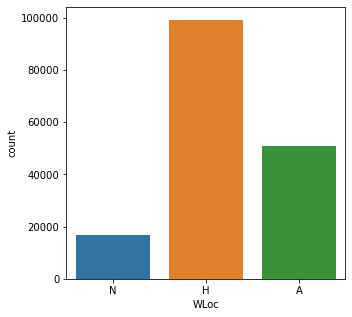

In [28]:
fig = plt.figure(figsize=(5, 5))
sns.countplot(data=MRegularSeasonCompactResults, x='WLoc');
plt.show()

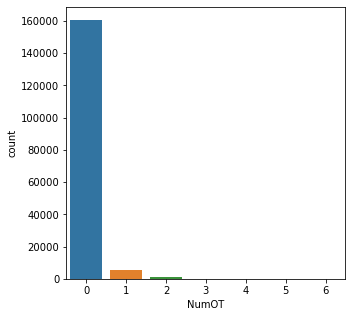

In [29]:
fig = plt.figure(figsize=(5, 5))
sns.countplot(data=MRegularSeasonCompactResults, x='NumOT');
plt.show()

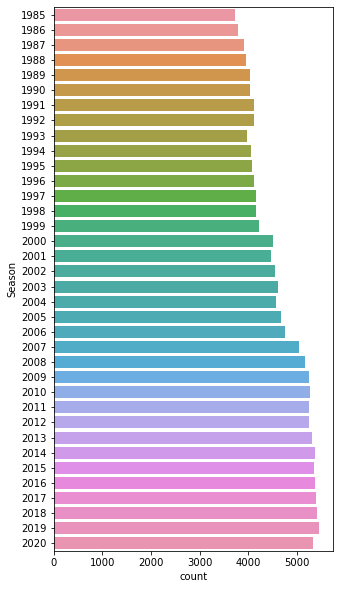

In [30]:
fig = plt.figure(figsize=(5, 10))
sns.countplot(data=MRegularSeasonCompactResults, y='Season');
plt.show()

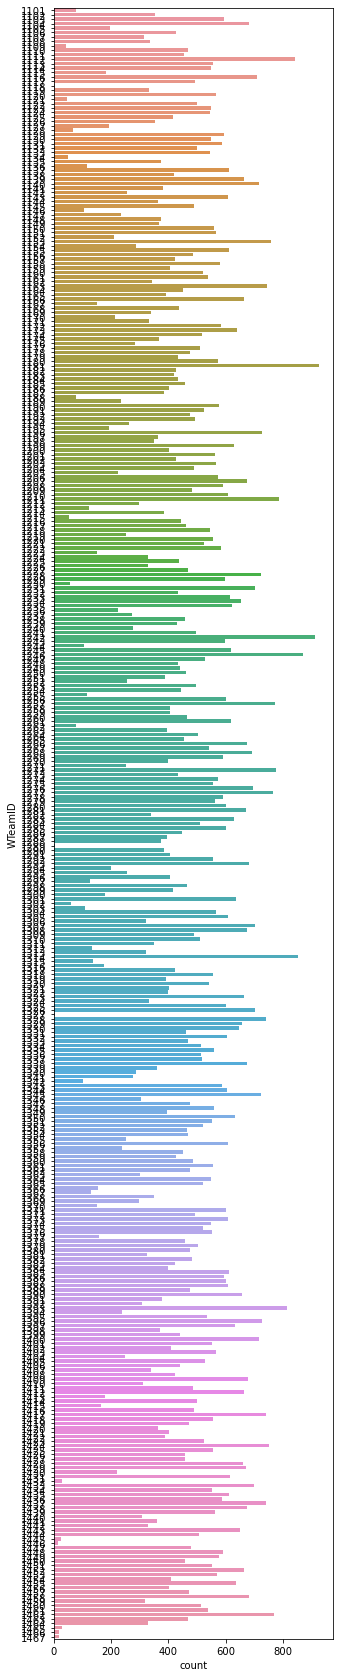

In [31]:
fig = plt.figure(figsize=(5, 30))
sns.countplot(data=MRegularSeasonCompactResults, y='WTeamID');
plt.show()

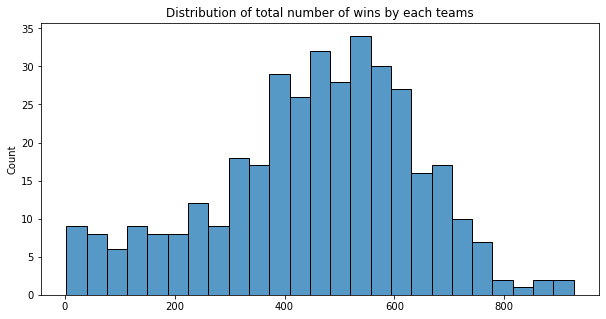

In [32]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(MRegularSeasonCompactResults.groupby("WTeamID").apply(lambda x: len(x)).values, bins=25);
plt.title("Distribution of total number of wins by each teams")
plt.show();

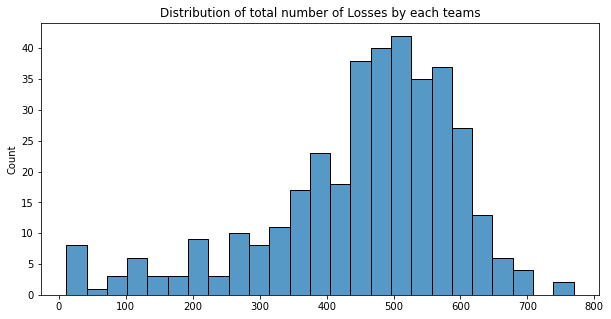

In [33]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(MRegularSeasonCompactResults.groupby("LTeamID").apply(lambda x: len(x)).values, bins=25);
plt.title("Distribution of total number of Losses by each teams")
plt.show();

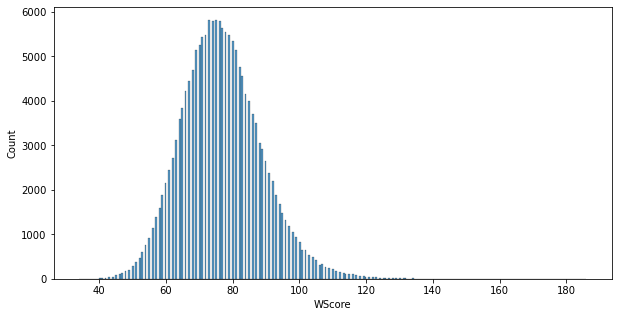

In [34]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MRegularSeasonCompactResults, x='WScore');
plt.show();

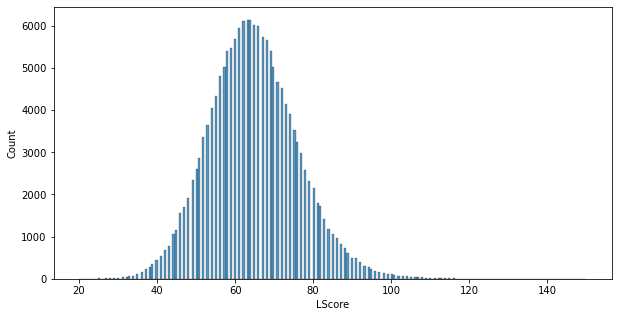

In [35]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MRegularSeasonCompactResults, x='LScore');
plt.show();

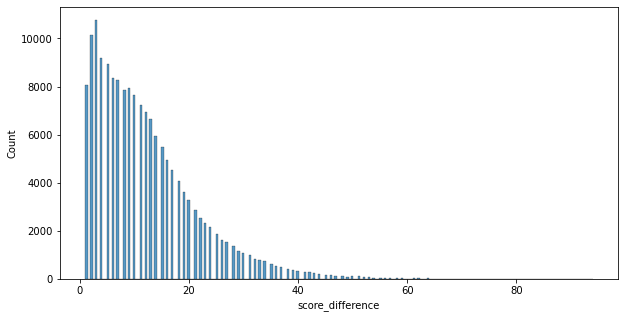

In [36]:
MRegularSeasonCompactResults["score_difference"] = \
    MRegularSeasonCompactResults["WScore"] -\
    MRegularSeasonCompactResults["LScore"]

fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MRegularSeasonCompactResults, x='score_difference');
plt.show();

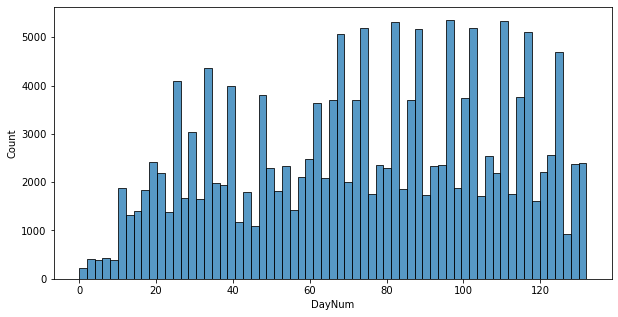

In [37]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MRegularSeasonCompactResults, x='DayNum');
plt.show();

## MNCAATourneyCompactResults.csv

This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

Because of the consistent structure of the NCAA® tournament schedule, you can actually tell what round a game was, depending on the exact DayNum. Thus:

* **DayNum=134 or 135 (Tue/Wed)** - play-in games to get the tournament field down to the final 64 teams
* **DayNum=136 or 137 (Thu/Fri)** - Round 1, to bring the tournament field from 64 teams to 32 teams
* **DayNum=138 or 139 (Sat/Sun)** - Round 2, to bring the tournament field from 32 teams to 16 teams
* **DayNum=143 or 144 (Thu/Fri)** - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams
* **DayNum=145 or 146 (Sat/Sun)** - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams
* **DayNum=152 (Sat)** - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams
* **DayNum=154 (Mon)** - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

In [38]:
MNCAATourneyCompactResults = pd.read_csv("../input/ncaam-march-mania-2021/MNCAATourneyCompactResults.csv")
MNCAATourneyCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [39]:
MNCAATourneyCompactResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0
2250,2019,154,1438,85,1403,77,N,1


In [40]:
MNCAATourneyCompactResults.shape

(2251, 8)

In [41]:
MNCAATourneyCompactResults.Season.value_counts()

2019    67
2012    67
2017    67
2015    67
2013    67
2011    67
2018    67
2016    67
2014    67
2001    64
2003    64
2005    64
2008    64
2010    64
2006    64
2004    64
2002    64
2007    64
2009    64
1995    63
1999    63
1997    63
1986    63
1993    63
1991    63
1989    63
1987    63
1988    63
2000    63
1998    63
1996    63
1994    63
1992    63
1990    63
1985    63
Name: Season, dtype: int64

In [42]:
len(MNCAATourneyCompactResults.Season.unique())

35

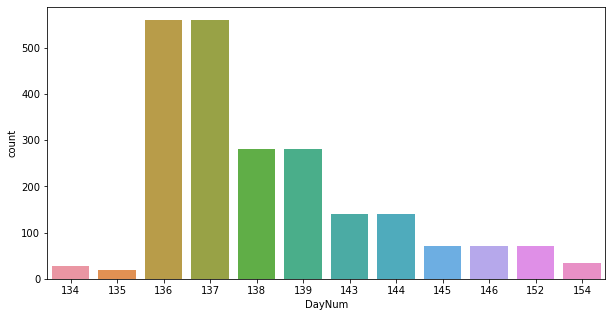

In [43]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=MNCAATourneyCompactResults, x='DayNum');
plt.show()

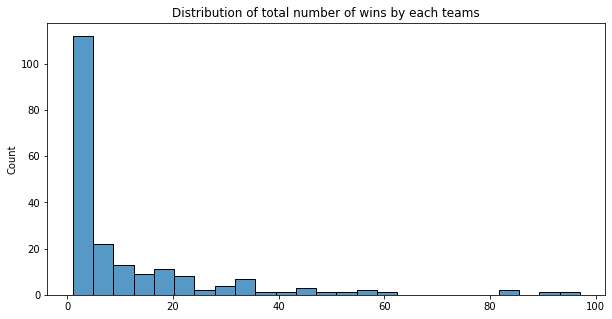

In [44]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(MNCAATourneyCompactResults.groupby("WTeamID").apply(lambda x: len(x)).values, bins=25);
plt.title("Distribution of total number of wins by each teams")
plt.show();

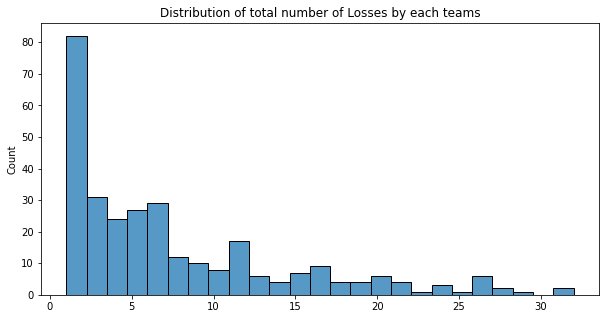

In [45]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(MNCAATourneyCompactResults.groupby("LTeamID").apply(lambda x: len(x)).values, bins=25);
plt.title("Distribution of total number of Losses by each teams")
plt.show();

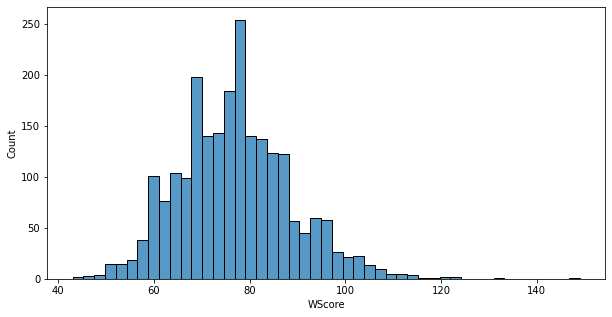

In [46]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MNCAATourneyCompactResults, x='WScore');
plt.show();

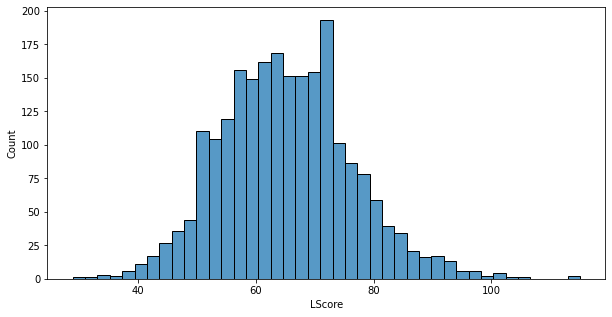

In [47]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MNCAATourneyCompactResults, x='LScore');
plt.show();

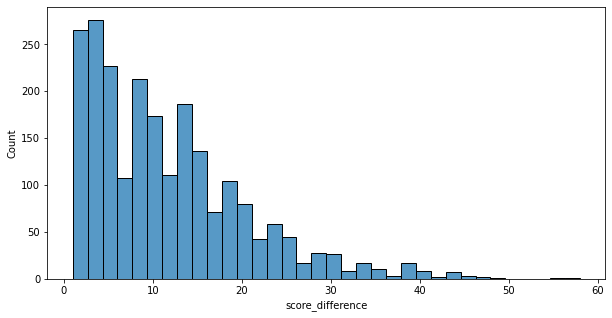

In [48]:
MNCAATourneyCompactResults["score_difference"] = \
    MNCAATourneyCompactResults["WScore"] -\
    MNCAATourneyCompactResults["LScore"]

fig = plt.figure(figsize=(10, 5))
sns.histplot(data=MNCAATourneyCompactResults, x='score_difference');
plt.show();

## MSampleSubmissionStage1.csv

This file illustrates the submission file format for Stage 1. It is the simplest possible submission: a 50% winning percentage is predicted for each possible matchup.

A submission file lists every possible matchup between tournament teams for one or more years. During Stage 1, you are asked to make predictions for all possible matchups from the past five NCAA® tournaments (seasons 2015, 2016, 2017, 2018, 2019). In Stage 2, you will be asked to make predictions for all possible matchups from the current NCAA® tournament (season 2021).

When there are 68 teams in the tournament, there are 68*67/2=2,278 predictions to make for that year, so a Stage 1 submission file will have 2,278*5=11,390 data rows.

* **ID** - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.

* **Pred** - this contains the predicted winning percentage for the first team identified in the ID field, the one represented above by XXXX.



Example #1: You want to make a prediction for Duke (TeamID=1181) against Arizona (TeamID=1112) in the 2017 tournament, with Duke given a 53% chance to win and Arizona given a 47% chance to win. In this case, Arizona has the lower numerical ID so they would be listed first, and the winning percentage would be expressed from Arizona's perspective (47%):

2017_1112_1181,0.47

Example #2: You want to make a prediction for Duke (TeamID=1181) against North Carolina (TeamID=1314) in the 2018 tournament, with Duke given a 51.6% chance to win and North Carolina given a 48.4% chance to win. In this case, Duke has the lower numerical ID so they would be listed first, and the winning percentage would be expressed from Duke's perspective (51.6%):

2018_1181_1314,0.516

Also note that a single prediction row serves as a prediction for each of the two teams' winning chances. So for instance, in Example #1, the submission row of "2017_1112_1181,0.47" specifically gives a 47% chance for Arizona to win, and doesn't explicitly mention Duke's 53% chance to win. However, our evaluation utility will automatically infer the winning percentage in the other direction, so a 47% prediction for Arizona to win also means a 53% prediction for Duke to win. And similarly, because the submission row in Example #2 gives Duke a 51.6% chance to beat North Carolina, we will automatically figure out that this also means North Carolina has a 48.4% chance to beat Duke.

In [49]:
MSampleSubmissionStage1 = pd.read_csv("../input/ncaam-march-mania-2021/MSampleSubmissionStage1.csv")
MSampleSubmissionStage1.head()

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


In [50]:
MSampleSubmissionStage1.head()

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


# Team Box Scores

This section provides game-by-game stats at a team level (free throws attempted, defensive rebounds, turnovers, etc.) for all regular season, conference tournament, and NCAA® tournament games since the 2002-03 season.

Team Box Scores are provided in "Detailed Results" files rather than "Compact Results" files. However, the two files are strongly related.

In a Detailed Results file, the first eight columns (Season, DayNum, WTeamID, WScore, LTeamID, LScore, WLoc, and NumOT) are exactly the same as a Compact Results file. However, in a Detailed Results file, there are many additional columns. The column names should be self-explanatory to basketball fans (as above, "W" or "L" refers to the winning or losing team):

* **WFGM** - field goals made (by the winning team)
* **WFGA** - field goals attempted (by the winning team)
* **WFGM3** - three pointers made (by the winning team)
* **WFGA3** - three pointers attempted (by the winning team)
* **WFTM** - free throws made (by the winning team)
* **WFTA** - free throws attempted (by the winning team)
* **WOR** - offensive rebounds (pulled by the winning team)
* **WDR** - defensive rebounds (pulled by the winning team)
* **WAst** - assists (by the winning team)
* **WTO** - turnovers committed (by the winning team)
* **WStl** - steals (accomplished by the winning team)
* **WBlk** - blocks (accomplished by the winning team)
* **WPF** - personal fouls committed (by the winning team)

(and then the same set of stats from the perspective of the losing team: LFGM is the number of field goals made by the losing team, and so on up to LPF).

Note: by convention, "field goals made" (either WFGM or LFGM) refers to the total number of fields goals made by a team, a combination of both two-point field goals and three-point field goals. And "three point field goals made" (either WFGM3 or LFGM3) is just the three-point fields goals made, of course. So if you want to know specifically about two-point field goals, you have to subtract one from the other (e.g., WFGM - WFGM3). And the total number of points scored is most simply expressed as 2*FGM + FGM3 + FTM.

## MRegularSeasonDetailedResults.csv

This file provides team-level box scores for many regular seasons of historical data, starting with the 2003 season. All games listed in the MRegularSeasonCompactResults file since the 2003 season should exactly be present in the MRegularSeasonDetailedResults file.

In [51]:
MRegularSeasonDetailedResults = pd.read_csv("../input/ncaam-march-mania-2021/MRegularSeasonDetailedResults.csv")
MRegularSeasonDetailedResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [52]:
MRegularSeasonDetailedResults.shape

(92832, 34)

In [53]:
MRegularSeasonDetailedResults.Season.value_counts()

2019    5463
2018    5405
2017    5395
2016    5369
2014    5362
2015    5354
2020    5328
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
Name: Season, dtype: int64

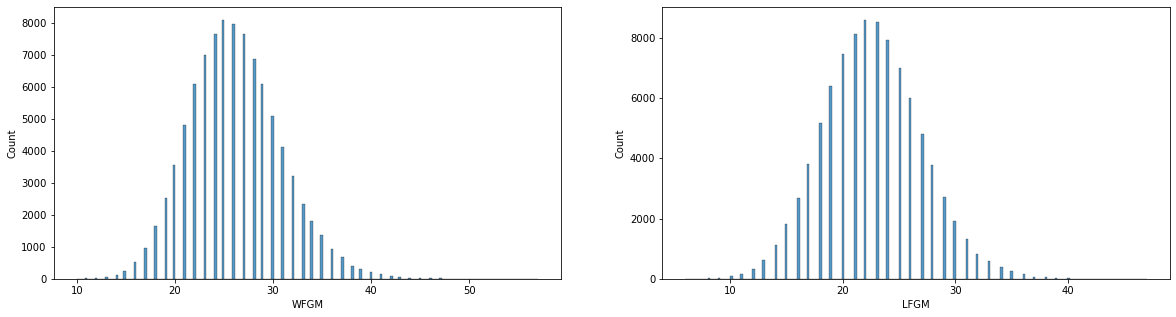

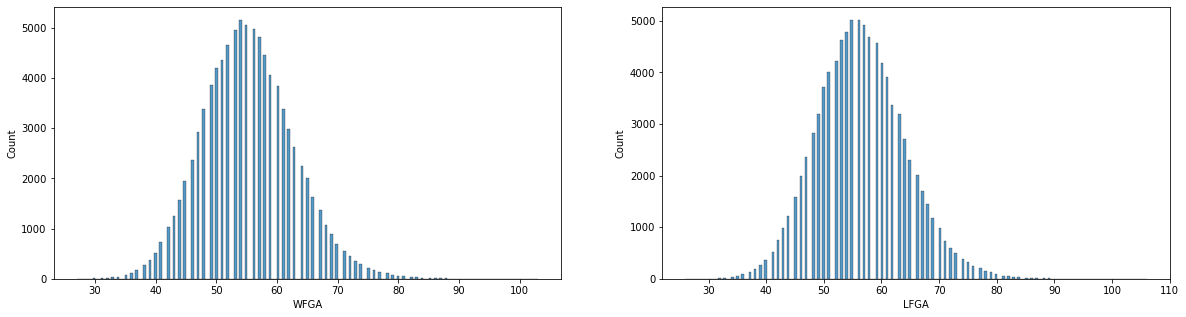

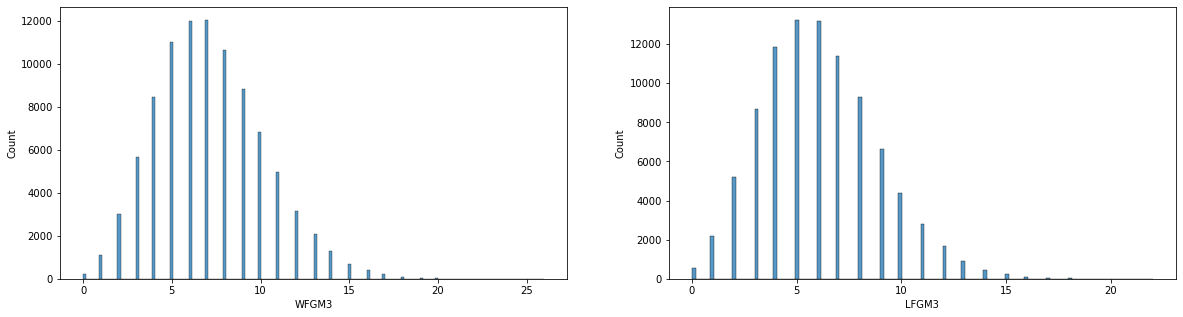

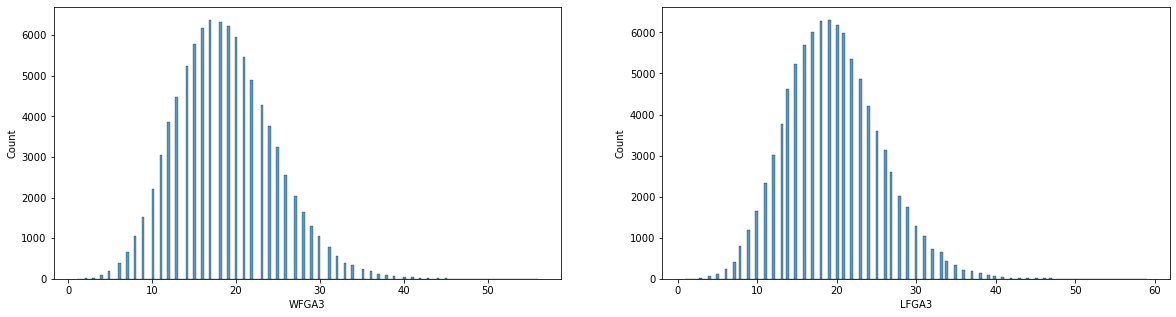

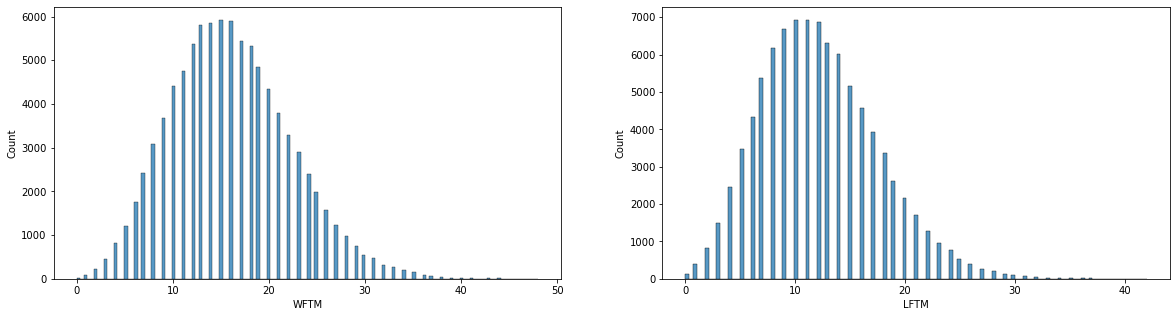

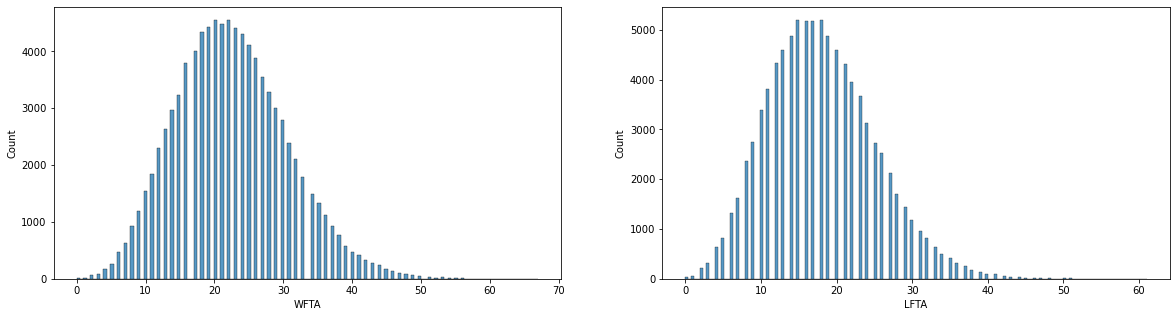

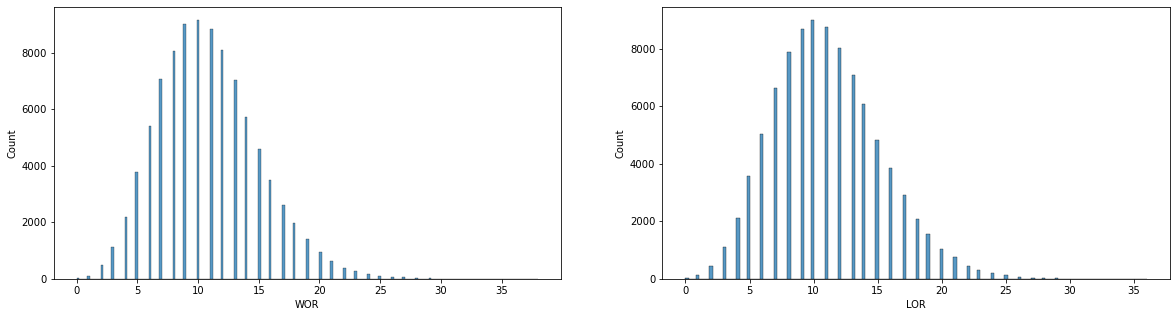

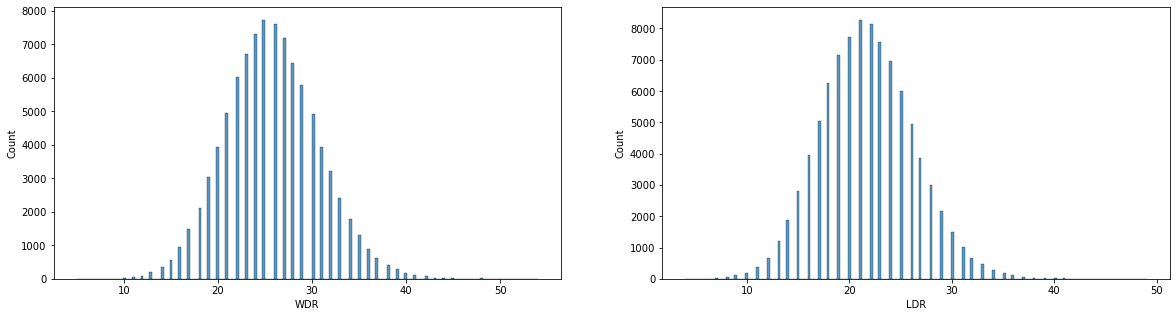

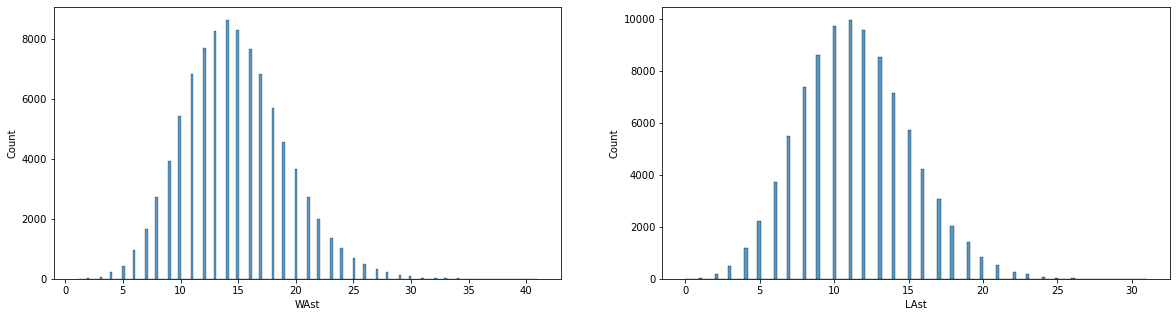

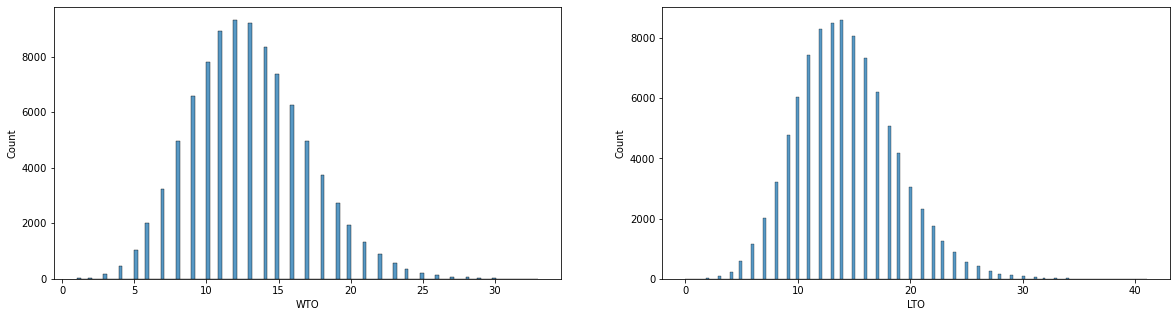

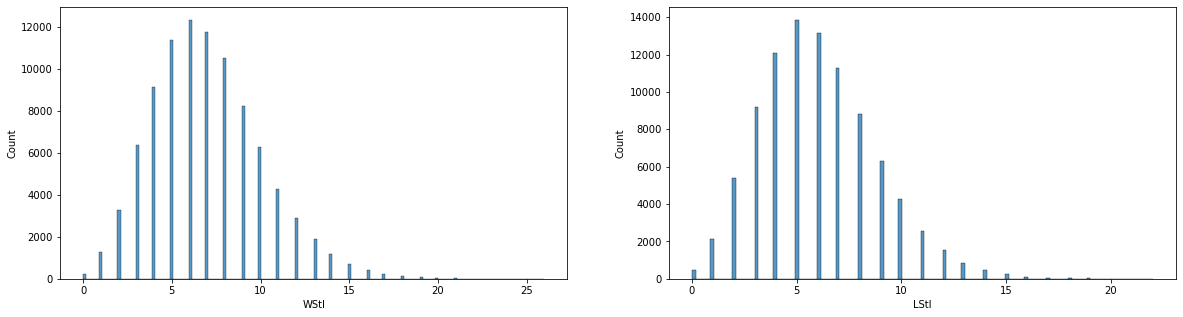

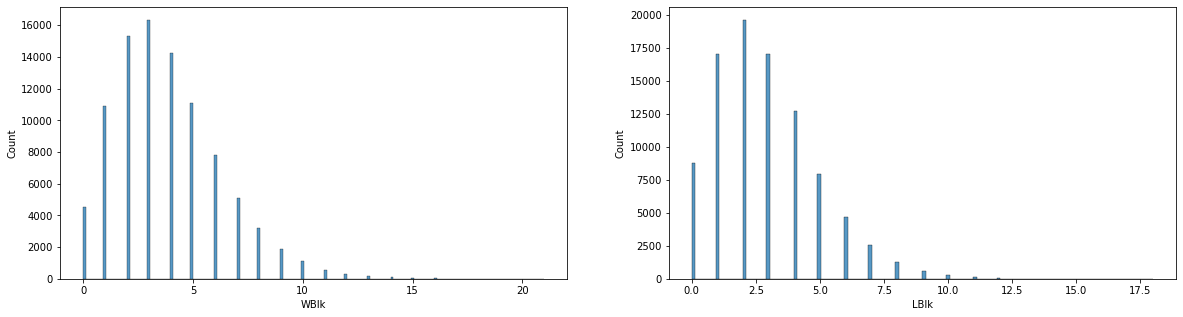

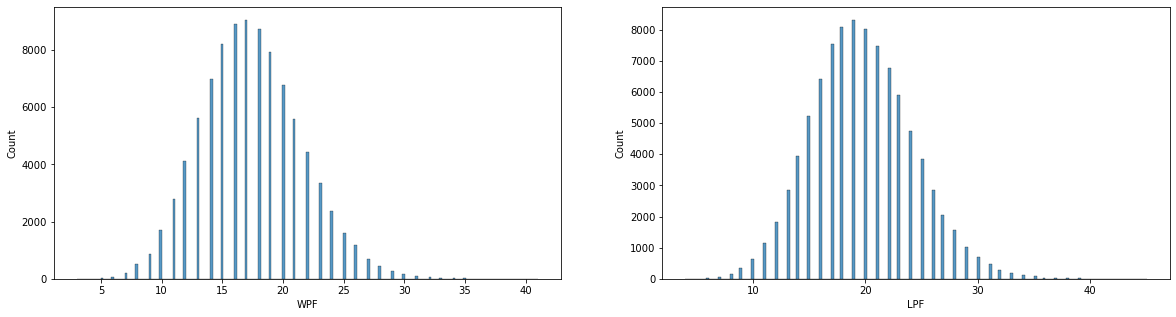

In [54]:
wnew_cols, lnew_cols = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], [ 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

for i, j in zip(wnew_cols, lnew_cols):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(ax=axes[0], data=MRegularSeasonDetailedResults, x=i);
    sns.histplot(ax=axes[1], data=MRegularSeasonDetailedResults, x=j);
    plt.show();

## MNCAATourneyDetailedResults.csv

This file provides team-level box scores for many NCAA® tournaments, starting with the 2003 season. All games listed in the MNCAATourneyCompactResults file since the 2003 season should exactly be present in the MNCAATourneyDetailedResults file.

In [55]:
MNCAATourneyDetailedResults = pd.read_csv("../input/ncaam-march-mania-2021/MNCAATourneyDetailedResults.csv")
MNCAATourneyDetailedResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [56]:
MNCAATourneyDetailedResults.shape

(1115, 34)

In [57]:
MNCAATourneyDetailedResults.Season.value_counts()

2011    67
2012    67
2018    67
2017    67
2016    67
2015    67
2014    67
2013    67
2019    67
2004    64
2010    64
2009    64
2008    64
2007    64
2006    64
2005    64
2003    64
Name: Season, dtype: int64

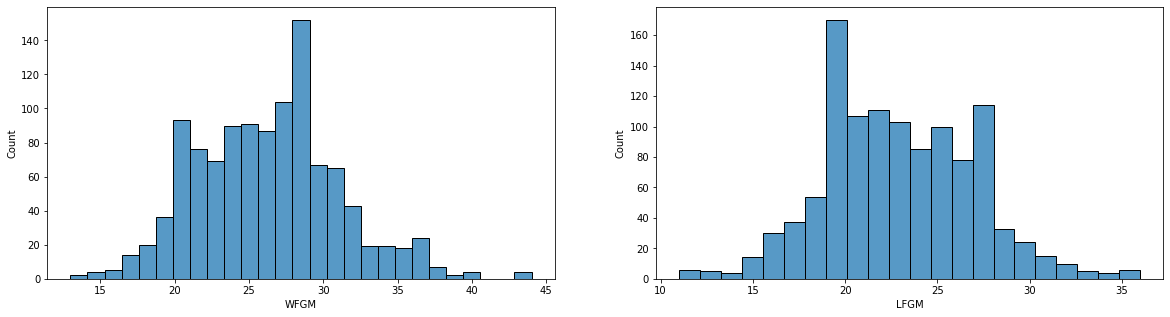

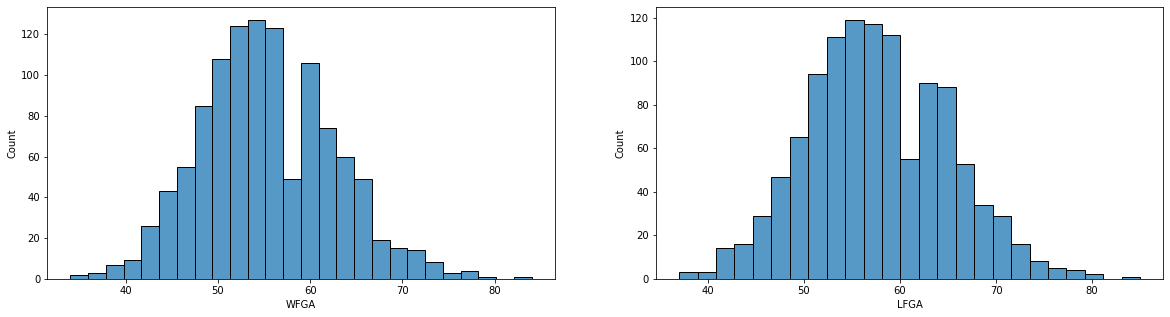

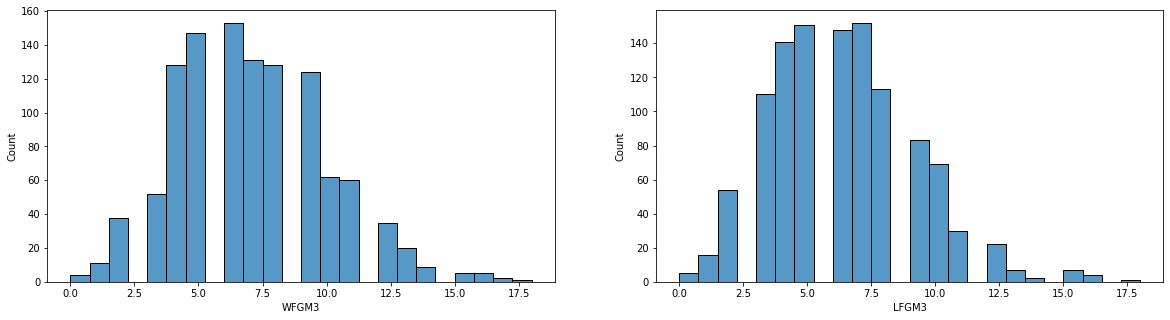

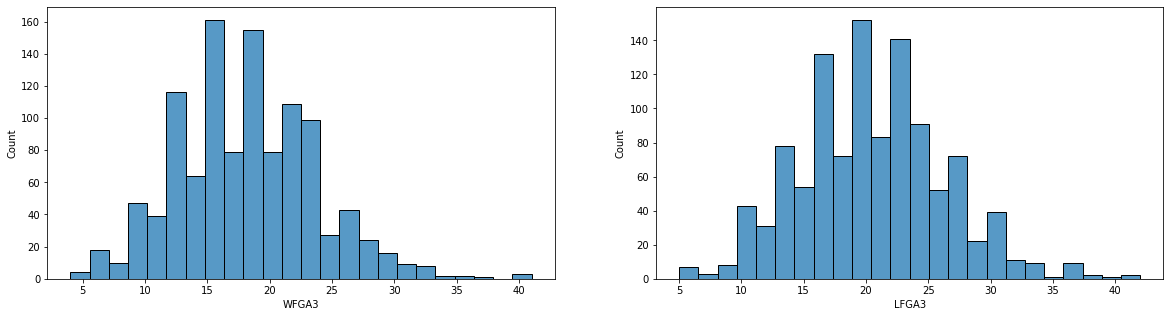

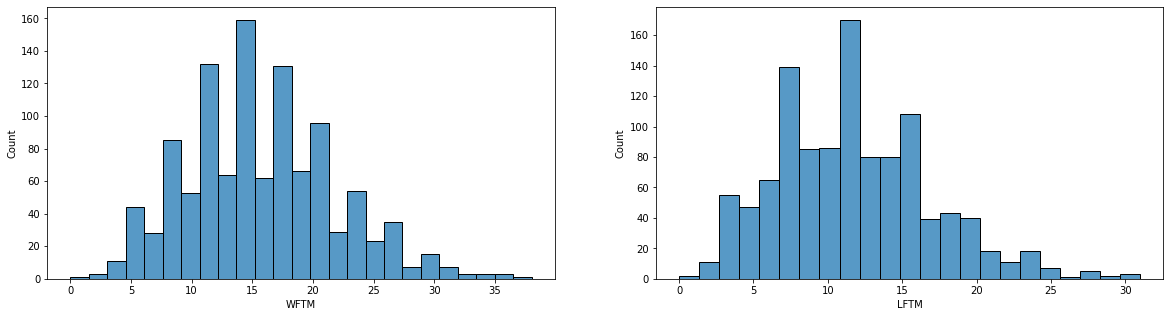

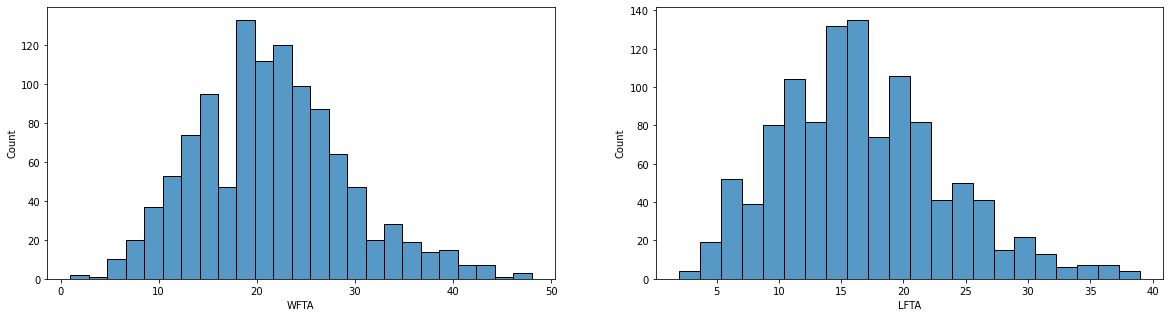

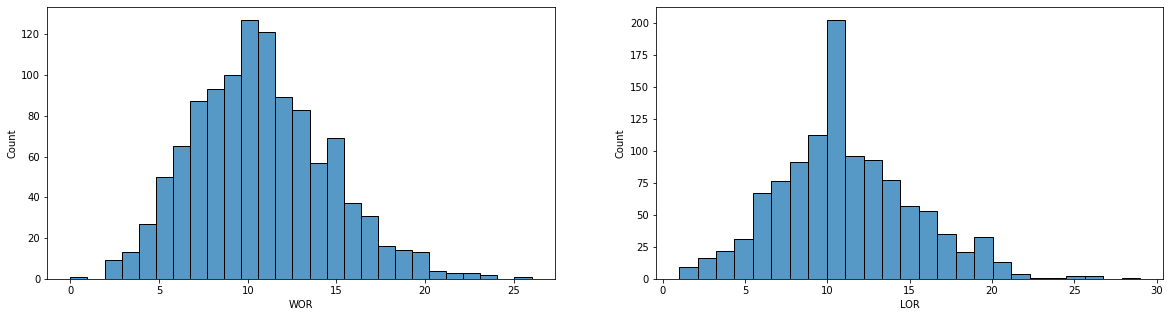

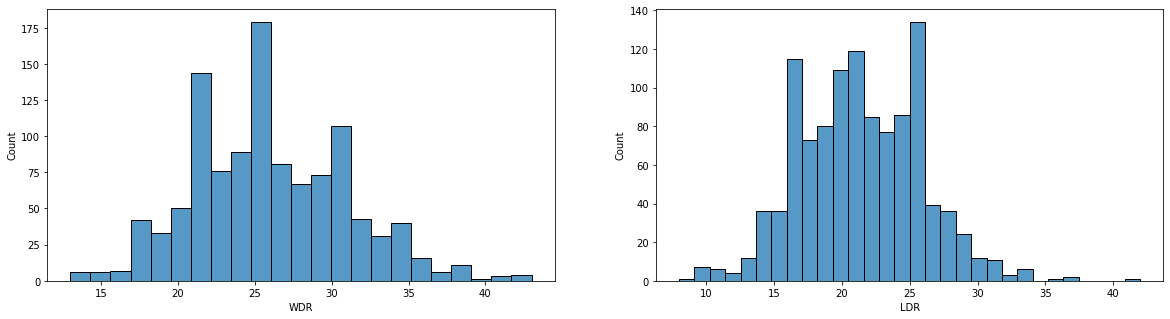

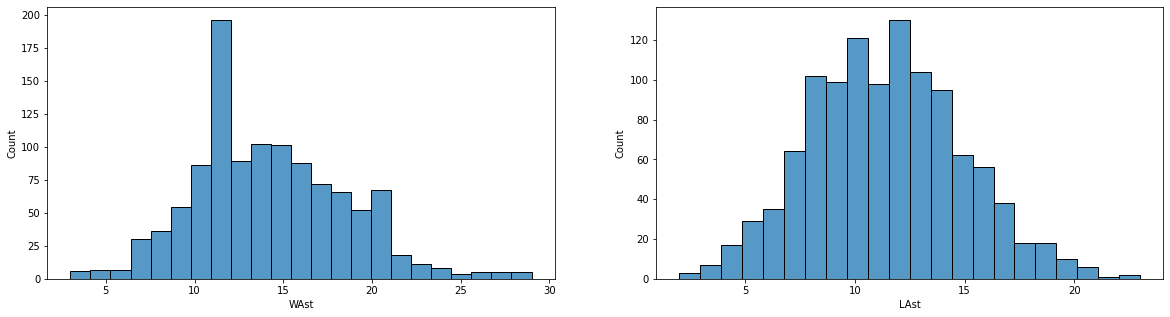

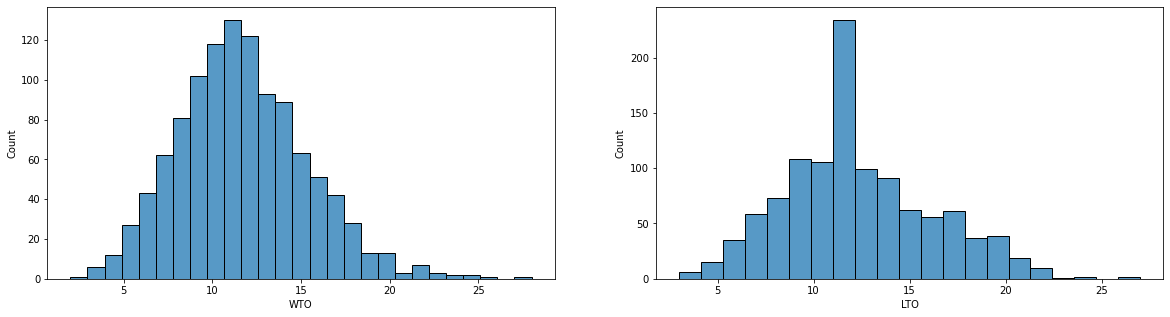

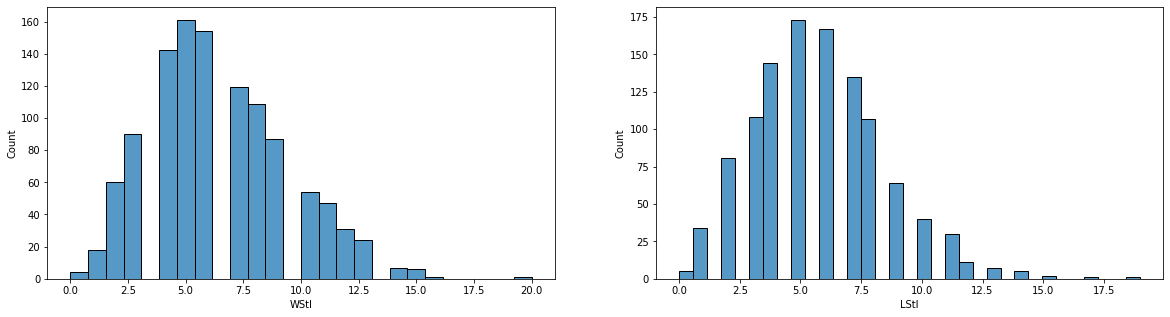

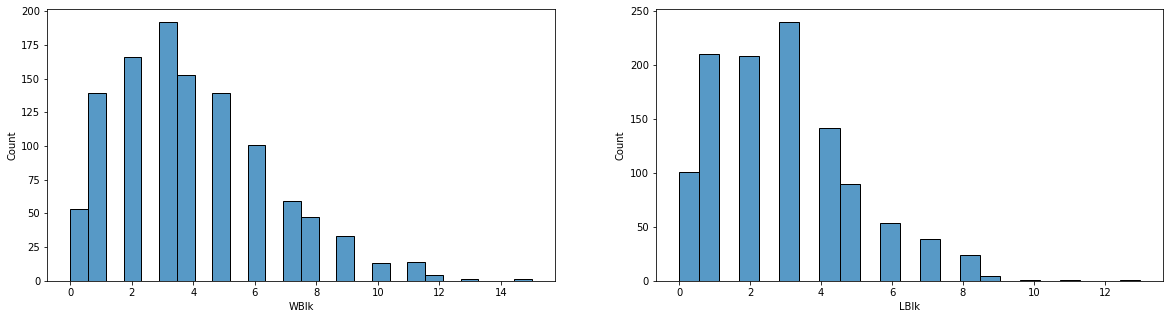

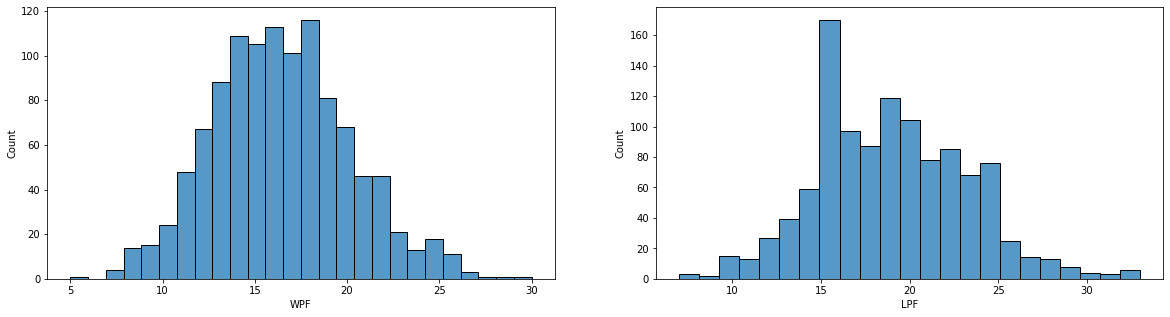

In [58]:
for i, j in zip(wnew_cols, lnew_cols):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(ax=axes[0], data=MNCAATourneyDetailedResults, x=i);
    sns.histplot(ax=axes[1], data=MNCAATourneyDetailedResults, x=j);
    plt.show();

# Geography

**This section provides city locations of all regular season, conference tournament, and NCAA® tournament games since the 2009-10 season**

## Cities.csv

This file provides a master list of cities that have been locations for games played. Please notice that the Cities and Conferences files are the only two that don't start with an M; this is because the data files are identical between men's and women's data, so you don't need to maintain separate listings of cities or conferences across the two contests. Also note that if you created any supplemental data last year on cities (latitude/longitude, altitude, etc.), the CityID's match between last year and this year, so you should be able to re-use that information.

* **CityID** - a four-digit ID number uniquely identifying a city.
* **City** - the text name of the city.
* **State** - the state abbreviation of the state that the city is in. In a few rare cases, the game location is not inside one of the 50 U.S. states and so other abbreviations are used. For instance Cancun, Mexico has a state abbreviation of MX.


In [59]:
Cities = pd.read_csv("../input/ncaam-march-mania-2021/Cities.csv")
Cities.head()

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH
2,4003,Albany,NY
3,4004,Albuquerque,NM
4,4005,Allentown,PA


In [60]:
Cities.shape

(453, 3)

In [61]:
len(Cities.City.unique())

425

In [62]:
len(Cities.State.unique())

63

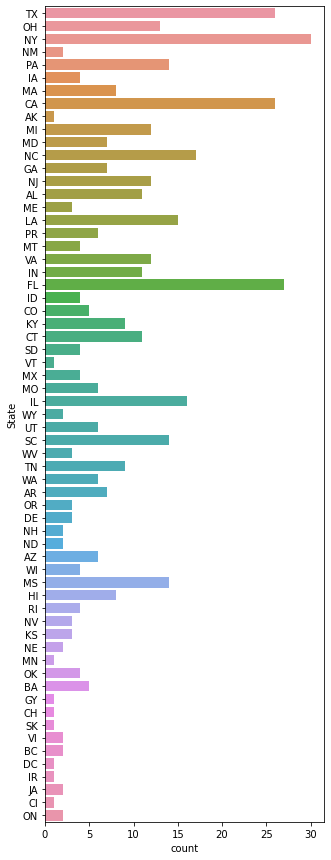

In [63]:
fig = plt.figure(figsize=(5, 15))
sns.countplot(data=Cities, y='State');
plt.show()

## MGameCities.csv

This file identifies all games, starting with the 2010 season, along with the city that the game was played in. Games from the regular season, the NCAA® tourney, and other post-season tournaments, are all listed together. There should be no games since the 2010 season where the CityID is not known. Games from the 2009 season and before are not listed in this file.

* **Season, DayNum, WTeamID, LTeamID** - these four columns are sufficient to uniquely identify each game. Additional data, such as the score of the game and other stats, can be found in the corresponding Compact Results and/or Detailed Results file.
* **CRType** - this can be either Regular or NCAA or Secondary. If it is Regular, you can find more about the game in the MRegularSeasonCompactResults.csv and MRegularSeasonDetailedResults.csv files. If it is NCAA, you can find more about the game in the MNCAATourneyCompactResults.csv and MNCAATourneyDetailedResults.csv files. If it is Secondary, you can find more about the game in the MSecondaryTourneyCompactResults file.
* **CityID** - the ID of the city where the game was played, as specified by the CityID column in the Cities.csv file.



In [64]:
MGameCities = pd.read_csv("../input/ncaam-march-mania-2021/MGameCities.csv")
MGameCities.head()

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,7,1143,1293,Regular,4027
1,2010,7,1314,1198,Regular,4061
2,2010,7,1326,1108,Regular,4080
3,2010,7,1393,1107,Regular,4340
4,2010,9,1143,1178,Regular,4027


In [65]:
MGameCities.shape

(60166, 6)

# Public Rankings

**This section provides weekly team rankings for dozens of top rating systems - Pomeroy, Sagarin, RPI, ESPN, etc., since the 2002-2003 season**

## MMasseyOrdinals.csv

This file lists out rankings (e.g. #1, #2, #3, ..., #N) of teams going back to the 2002-2003 season, under a large number of different ranking system methodologies. The information was gathered by Kenneth Massey and provided on his College Basketball Ranking Composite page.

Note that a rating system is more precise than a ranking system, because a rating system can provide insight about the strength gap between two adjacently-ranked teams. A ranking system will just tell you who is #1 or who is #2, but a rating system might tell you whether the gap between #1 and #2 is large or small. Nevertheless, it can be hard to compare two different rating systems that are expressed in different scales, so it can be very useful to express all the systems in terms of their ordinal ranking (1, 2, 3, ..., N) of teams.

* **Season** - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)
* **RankingDayNum** - this integer always ranges from 0 to 133, and is expressed in the same terms as a game's DayNum (where DayZero is found in the MSeasons.csv file). The RankingDayNum is intended to tell you the first day that it is appropriate to use the rankings for predicting games. For example, if RankingDayNum is 110, then the rankings ought to be based upon game outcomes up through DayNum=109, and so you can use the rankings to make predictions of games on DayNum=110 or later. The final pre-tournament rankings each year have a RankingDayNum of 133, and can thus be used to make predictions of the games from the NCAA® tournament, which start on DayNum=134 (the Tuesday after Selection Sunday).
* **SystemName** - this is the (usually) 3-letter abbreviation for each distinct ranking system. These systems may evolve from year to year, but as a general rule they retain their meaning across the years. Near the top of the Massey composite page, you can find slightly longer labels describing each system, along with links to the underlying pages where the latest rankings are provided (and sometimes the calculation is described).
* **TeamID** - this is the ID of the team being ranked, as described in MTeams.csv.
* **OrdinalRank** - this is the overall ranking of the team in the underlying system. Most systems from recent seasons provide a complete ranking from #1 through #351, but sometimes there are ties and sometimes only a smaller set of rankings is provided, as with the AP's top 25. This year and last year they will typically go up to #353 because two new teams were added to Division I last year.


In [66]:
MMasseyOrdinals = pd.read_csv("../input/ncaam-march-mania-2021/MMasseyOrdinals.csv")
MMasseyOrdinals.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [67]:
MMasseyOrdinals.shape

(4120886, 5)

In [68]:
len(MMasseyOrdinals.TeamID.unique())

358

In [69]:
len(MMasseyOrdinals.SystemName.unique())

179

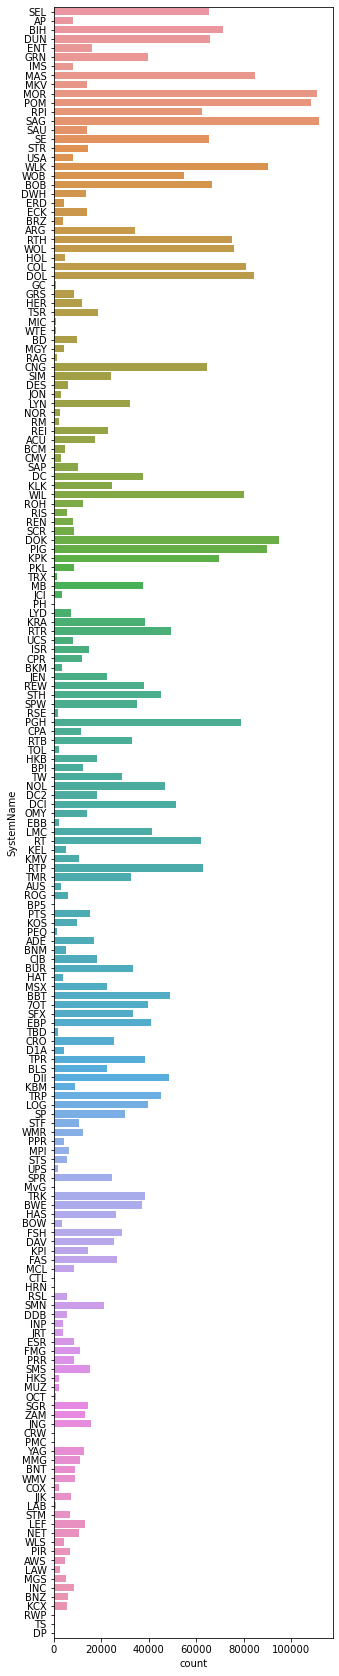

In [70]:
fig = plt.figure(figsize=(5, 30))
sns.countplot(data=MMasseyOrdinals, y='SystemName');
plt.show()

In [71]:
co_mat = pd.crosstab(MMasseyOrdinals.Season, MMasseyOrdinals.SystemName)
pd.set_option('display.max_columns', 200)
co_mat

SystemName,7OT,ACU,ADE,AP,ARG,AUS,AWS,BBT,BCM,BD,BIH,BKM,BLS,BNM,BNT,BNZ,BOB,BOW,BP5,BPI,BRZ,BUR,BWE,CJB,CMV,CNG,COL,COX,CPA,CPR,CRO,CRW,CTL,D1A,DAV,DC,DC2,DCI,DDB,DES,DII,DOK,DOL,DP,DUN,DWH,EBB,EBP,ECK,ENT,ERD,ESR,FAS,FMG,FSH,GC,GRN,GRS,HAS,HAT,HER,HKB,HKS,HOL,HRN,IMS,INC,INP,ISR,JCI,JEN,JJK,JNG,JON,JRT,KBM,KCX,KEL,KLK,KMV,KOS,KPI,KPK,KRA,LAB,LAW,LEF,LMC,LOG,LYD,LYN,MAS,MB,MCL,MGS,MGY,MIC,MKV,MMG,MOR,MPI,MSX,MUZ,MvG,NET,NOL,NOR,OCT,OMY,PEQ,PGH,PH,PIG,PIR,PKL,PMC,POM,PPR,PRR,PTS,RAG,REI,REN,REW,RIS,RM,ROG,ROH,RPI,RSE,RSL,RT,RTB,RTH,RTP,RTR,RWP,SAG,SAP,SAU,SCR,SE,SEL,SFX,SGR,SIM,SMN,SMS,SP,SPR,SPW,STF,STH,STM,STR,STS,TBD,TMR,TOL,TPR,TRK,TRP,TRX,TS,TSR,TW,UCS,UPS,USA,WIL,WLK,WLS,WMR,WMV,WOB,WOL,WTE,YAG,ZAM
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,0,0,0,375,3597,0,0,0,0,0,4905,0,0,0,0,0,4578,0,0,0,3924,0,0,0,0,0,2289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2289,0,4578,4251,0,0,3924,4905,4251,0,0,0,0,975,4905,2289,0,0,2289,0,0,2943,0,4251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4905,0,0,0,0,972,4905,0,4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4905,0,0,0,0,0,0,0,0,0,0,0,4905,0,0,0,0,3597,0,0,0,4905,0,4905,0,4905,4905,0,0,0,0,0,0,0,0,0,0,0,4905,0,0,0,0,0,0,0,0,0,1635,0,0,0,375,0,4905,0,0,0,4905,3597,981,0,0
2004,0,0,0,451,3586,0,0,0,0,5216,5216,0,0,0,0,0,3586,0,0,0,0,0,0,0,0,3586,2934,0,0,0,0,0,0,0,0,0,0,0,0,250,0,0,4564,0,0,3912,0,0,3260,5216,0,0,0,0,0,0,4238,4561,0,0,4890,0,0,1956,0,0,0,0,0,0,0,0,0,3260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1128,5868,0,0,0,4564,0,4238,0,4238,0,0,0,0,0,0,2608,0,0,0,0,0,0,0,0,0,5868,0,0,0,652,1628,0,0,0,2281,0,0,4238,0,0,0,0,3024,0,0,0,5868,0,4238,0,0,4238,0,0,3586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3586,0,0,0,451,0,4890,0,0,0,5216,2934,0,0,0
2005,0,2018,0,451,3630,0,0,0,3960,4620,3300,0,0,0,0,0,3630,0,0,0,0,0,0,0,3299,3959,3960,0,0,0,0,0,0,0,0,4290,0,0,0,300,0,0,3630,0,0,3296,0,0,3630,5940,0,0,0,0,0,0,4620,0,0,0,4950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4290,0,0,0,0,0,0,0,0,0,0,0,1588,4290,0,0,0,0,0,0,0,5940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5940,0,0,0,660,0,1320,0,2970,0,0,3952,3960,0,0,0,0,1650,0,0,0,5940,4290,0,330,0,4290,0,0,5241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2970,0,0,0,453,3960,4620,0,0,0,3958,3300,0,0,0
2006,0,1014,0,450,0,0,0,0,990,0,2670,0,0,0,0,0,4658,0,0,0,0,0,0,0,0,3004,4000,0,0,0,0,0,0,0,0,3004,0,0,0,0,0,5972,4991,0,5645,668,0,0,1002,0,0,0,0,0,0,0,3992,0,0,0,0,0,0,0,0,0,0,0,0,2004,0,0,0,0,0,0,0,0,0,0,0,0,4659,0,0,0,0,0,0,0,2486,0,3332,0,0,0,0,0,0,5972,0,0,0,0,0,0,0,0,0,0,0,326,5276,0,4664,0,5972,0,0,0,0,0,3666,0,2656,0,0,4664,1670,0,0,0,0,3997,0,0,0,5972,2672,0,3004,5318,4328,0,0,4653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,440,0,1328,0,0,0,450,0,4664,0,0,0,2336,4327,0,0,0
2007,0,1920,0,375,0,0,0,0,0,0,3012,0,0,0,0,0,5010,0,0,0,0,0,0,0,0,4680,5005,0,0,336,0,0,0,0,0,3024,0,0,0,0,0,5010,3690,0,672,1617,0,0,0,0,0,0,0,0,0,0,4995,0,0,0,0,0,0,0,0,0,0,0,1680,1680,0,0,0,0,0,0,0,0,1680,0,0,0,0,3960,0,0,0,0,0,4319,2675,0,3024,0,0,0,0,0,0,5010,0,0,0,0,0,0,0,0,0,0,0,0,2352,0,4020,0,5010,0,0,0,0,0,3018,0,0,0,0,3690,4020,0,0,0,0,4350,0,3360,0,5010,3360,0,3024,5010,3024,0,0,5008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4350,0,2688,0,376,1680,4680,0,0,0,3960,4020,0,0,0
2008,0,0,0,500,0,0,0,0,0,0,3751,3751,0,0,0,0,5456,0,0,0,0,0,0,0,0,4774,4433,0,341,682,0,0,0,0,0,2387,0,0,0,275,0,6815,3751,0,3751,0,0,0,2387,0,0,0,0,0,0,0,4759,0,0,0,0,0,0,0,0,4093,0,0,3410,0,3370,0,0,0,0,0,0,0,3410,0,0,0,0,3069,0,0,0,0,0,2386,3281,0,4774,0,0,0,0,0,0,6816,0,0,0,0,0,0,0,0,0,0,1364,0,6407,0,0,0,4774,0,0,0,0,1023,0,3408,0,0,0,0,4092,1705,0,0,0,4774,0,4433,0,6820,0,0,2387,6479,1365,0,0,4433,0,0,0,0,2728,0,3392,0,3729,0,0,0,0,0,0,0,0,0,4774,0,2387,0,500,4774,4774,0,0,0,3069,3751,0,0,0
2009,0,0,0,475,0,0,0,0,0,0,0,0,0,0,0,0,4858,0,0,4164,0,0,0,0,0,3784,4459,0,347,347,0,0,0,0,0,3087,2408,2408,0,450,0,6230,5831,0,4502,0,343,0,0,0,0,0,0,0,0,0,5477,0,0,0,0,3784,0,0,0,0,0,0,4802,0,4044,0,0,0,0,0,0,0,4802,0

# Supplements


**This section contains additional supporting information, including coaches, conference affiliations, alternative team name spellings, bracket structure, and game results for NIT and other postseason tournaments.**

## MTeamCoaches.csv

This file indicates the head coach for each team in each season, including a start/finish range of DayNum's to indicate a mid-season coaching change. For scenarios where a team had the same head coach the entire season, they will be listed with a DayNum range of 0 to 154 for that season. For head coaches whose term lasted many seasons, there will be many rows listed, most of which have a DayNum range of 0 to 154 for the corresponding season.

* **Season** - this is the year of the associated entry in MSeasons.csv (the calendar year in which the final tournament occurs)
* **TeamID** - this is the TeamID of the team that was coached, as described in MTeams.csv.
* **FirstDayNum, LastDayNum** - this defines a continuous range of days within the season, during which the indicated coach was the head coach of the team. In most cases, a data row will either have FirstDayNum=0 (meaning they started the year as head coach) and/or LastDayNum=154 (meaning they ended the year as head coach), but in some cases there were multiple new coaches during a team's season, or a head coach who went on leave and then returned (in which case there would be multiple records in that season for that coach, indicating the continuous ranges of days when they were the head coach).
* **CoachName** - this is a text representation of the coach's full name, in the format first_last, with underscores substituted in for spaces.


In [72]:
MTeamCoaches = pd.read_csv("../input/ncaam-march-mania-2021/MTeamCoaches.csv")
MTeamCoaches.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney


In [73]:
MTeamCoaches.shape

(11704, 5)

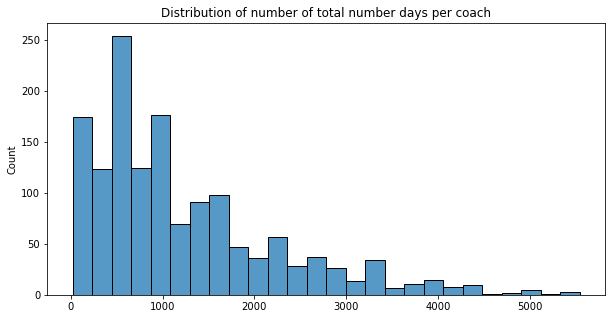

In [74]:
MTeamCoaches['TotalDays'] = MTeamCoaches['LastDayNum'] - MTeamCoaches['FirstDayNum'] 
fig = plt.figure(figsize=(10, 5))
sns.histplot(MTeamCoaches.groupby('CoachName')['TotalDays'].sum().values);
plt.title("Distribution of number of total number days per coach")
plt.show();

## Conferences.csv

This file indicates the Division I conferences that have existed over the years since 1985. Each conference is listed with an abbreviation and a longer name. There has been no attempt to link up conferences who merged with other conferences, or whose names changed over time. Thus you will see, for instance, a "Pacific-10" conference up through the 2011 season, and then a "Pacific-12" conference starting in the 2012 season, and these look like different conferences in the data, even though it was still mostly the same teams. Please notice that the Cities and Conferences files are the only two that don't start with an M; this is because the data files are identical between men's and women's data, so you don't need to maintain separate listings of cities or conferences across the two contests. However, the Team Conferences data differs slightly between men's and women's, so those files do have the prefixes.

* **ConfAbbrev** - this is a short abbreviation for each conference; the abbreviation is used in some other files to indicate the parent conference of a team or of a conference tournament.
* **Description** - this is a longer text name for the conference.



In [75]:
Conferences = pd.read_csv("../input/ncaam-march-mania-2021/Conferences.csv")
Conferences.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [76]:
Conferences.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


## MTeamConferences.csv

This file indicates the conference affiliations for each team during each season. Some conferences have changed their names from year to year, and/or changed which teams are part of the conference. This file tracks this information historically.

* **Season** - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)
* **TeamID** - this identifies the TeamID (as described in MTeams.csv).
* **ConfAbbrev** - this identifies the conference (as described in Conferences.csv).

In [77]:
MTeamConferences = pd.read_csv("../input/ncaam-march-mania-2021/MTeamConferences.csv")
MTeamConferences.head()

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


In [78]:
MTeamConferences.shape

(11941, 3)

## MConferenceTourneyGames.csv


This file indicates which games were part of each year's post-season conference tournaments (all of which finished on Selection Sunday or earlier), starting from the 2001 season. Many of these conference tournament games are held on neutral sites, and many of the games are played by tournament-caliber teams just a few days before the NCAA® tournament. Thus these games could be considered as very similar to NCAA® tournament games, and (depending on your methodology) may be of use in optimizing your predictions. However, this is NOT a new listing of games; these games are already present within the MRegularSeasonCompactResults and MRegularSeasonDetailedResults files. So this file simply helps you to identify which of the "regular season" games since the 2001 season were actually conference tournament games, in case that is useful information.

* **ConfAbbrev** - this identifies the conference (as described in Conferences.csv) that the tournament was for.
* **Season, DayNum, WTeamID, LTeamID** - these four columns are sufficient to uniquely identify each game. Further details about the game, such as the final score and other stats, can be found in the associated data row of the MRegularSeasonCompactResults and/or MRegularSeasonDetailedResults files.


In [79]:
MConferenceTourneyGames = pd.read_csv("../input/ncaam-march-mania-2021/MConferenceTourneyGames.csv")
MConferenceTourneyGames.head()

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273


In [80]:
MConferenceTourneyGames.shape

(5308, 5)

## MSecondaryTourneyTeams.csv

This file identifies the teams that participated in post-season tournaments other than the NCAA® Tournament (such events would run in parallel with the NCAA® Tournament). These are teams that were not invited to the NCAA® Tournament and instead were invited to some other tournament, of which the NIT is the most prominent tournament, but there have also been the CBI, CIT, and Vegas 16 (V16) at various points in recent years. Depending on your methodology, you might find it useful to have these additional game results, above and beyond what is available from the NCAA® Tournament results. Many of these teams, especially in the NIT, were "bubble" teams of comparable strength to several NCAA® Tournament invitees, and so these games may be of use in model optimization for predicting NCAA® Tournament results. Also note that this information could be determined just from inspecting the MSecondaryTourneyCompactResults file, but is presented in this file as well, for your convenience.

* **Season** - this is the year of the associated entry in MSeasons.csv (the year in which the post-season tournament was played)
* **SecondaryTourney** - this is the abbreviation of the tournament, either NIT, CBI, CIT, or V16 (which stands for Vegas 16).
* **TeamID** - this identifies the TeamID that participated in the tournament (as described in MTeams.csv* ****

In [81]:
MSecondaryTourneyTeams = pd.read_csv("../input/ncaam-march-mania-2021/MSecondaryTourneyTeams.csv")
MSecondaryTourneyTeams.head()

,Season,SecondaryTourney,TeamID
0,1985,NIT,1108
1,1985,NIT,1133
2,1985,NIT,1139
3,1985,NIT,1145
4,1985,NIT,1151


In [82]:
MSecondaryTourneyTeams.shape

(1642, 3)

## MSecondaryTourneyCompactResults.csv

This file indicates the final scores for the tournament games of "secondary" post-season tournaments: the NIT, CBI, CIT, and Vegas 16. The detailed results (team box scores) have not been assembled for these games. For the most part, this file is exactly like other Compact Results listings, although it also has a column for Secondary Tourney. Also note that because these games are played after DayNum=132, they are NOT listed in the MRegularSeasonCompactResults file.
* **SecondaryTourney** - this is the abbreviation of the tournament, either NIT, CBI, CIT, or V16 (which stands for Vegas 16).

In [83]:
MSecondaryTourneyCompactResults = pd.read_csv("../input/ncaam-march-mania-2021/MSecondaryTourneyCompactResults.csv")
MSecondaryTourneyCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SecondaryTourney
0,1985,136,1151,67,1155,65,H,0,NIT
1,1985,136,1153,77,1245,61,H,0,NIT
2,1985,136,1201,79,1365,76,H,0,NIT
3,1985,136,1231,79,1139,57,H,0,NIT
4,1985,136,1249,78,1222,71,H,0,NIT


In [84]:
MSecondaryTourneyCompactResults.shape

(1624, 9)

## MTeamSpellings.csv

This file indicates alternative spellings of many team names. It is intended for use in associating external spellings against our own TeamID numbers, thereby helping to relate the external data properly with our datasets. Over the years we have identified various external spellings of different team names (as an example, for Ball State we have seen "ball st", and "ball st.", and "ball state", and "ball-st", and "ball-state"). Other teams have had more significant changes to their names over the years; for example, "Texas Pan-American" and "Texas-Rio Grande Valley" are actually the same school. The current list is obviously not exhaustive, and we encourage participants to identify additional mappings and upload extended versions of this file to the forums.

* **TeamNameSpelling** - this is the spelling of the team name. It is always expressed in all lowercase letters - e.g. "ball state" rather than "Ball State" - in order to emphasize that any comparisons should be case-insensitive when matching.
* **TeamID** - this identifies the TeamID for the team that has the alternative spelling (as described in MTeams.csv).


In [85]:
MTeamSpellings = pd.read_csv("../input/ncaam-march-mania-2021/MTeamSpellings.csv", encoding = "ISO-8859-1")
MTeamSpellings.head()

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene-christian,1101


In [86]:
MTeamSpellings.shape

(1147, 2)

## MNCAATourneySlots.csv

This file identifies the mechanism by which teams are paired against each other, depending upon their seeds, as the tournament proceeds through its rounds. It can be of use in identifying, for a given historical game, what round it occurred in, and what the seeds/slots were for the two teams (the meaning of "slots" is described below). Because of the existence of play-in games for particular seed numbers, the pairings have small differences from year to year. You may need to know these specifics if you are trying to represent/simulate the exact workings of the tournament bracket.

* **Season** - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)
* **Slot** - this uniquely identifies one of the tournament games. For play-in games, it is a three-character string identifying the seed fulfilled by the winning team, such as W16 or Z13. For regular tournament games, it is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. Even if that R2W1 slot were actually a game between the W09 and W16 teams, it is still considered to be the R2W1 slot. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.
* **StrongSeed** - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the MNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "StrongSeed", which during the 1985 tournament would have been Georgetown. Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", since you would have #1 seeds favored to face each other, but those games are nevertheless represented in the same format for the sake of consistency.
* **WeakSeed** - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the MNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column.


In [87]:
MNCAATourneySlots = pd.read_csv("../input/ncaam-march-mania-2021/MNCAATourneySlots.csv")
MNCAATourneySlots.head()

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12


In [88]:
MNCAATourneySlots.shape

(2251, 4)

## MNCAATourneySeedRoundSlots.csv

This file helps to represent the bracket structure in any given year. No matter where the play-in seeds are located, we can always know, for a given tournament seed, exactly what bracket slot they would be playing in, on each possible game round, and what the possible DayNum values would be for that round. Thus, if we know when a historical game was played, and what the team's seed was, we can identify the slot for that game. This can be useful in representing or simulating the tournament bracket structure.

* **Seed** - this is the tournament seed of the team.
* **GameRound** - this is the round during the tournament that the game would occur in, where Round 0 (zero) is for the play-in games, Rounds 1/2 are for the first weekend, Rounds 3/4 are for the second weekend, and Rounds 5/6 are the national semifinals and finals.
* **GameSlot** - this is the game slot that the team would be playing in, during the given GameRound. The naming convention for slots is described above, in the definition of the MNCAATourneySlots file.
* **EarlyDayNum**, LateDayNum - these fields describe the earliest possible, and latest possible, DayNums that the game might be played on.

In [89]:
MNCAATourneySeedRoundSlots = pd.read_csv("../input/ncaam-march-mania-2021/MNCAATourneySeedRoundSlots.csv")
MNCAATourneySeedRoundSlots.head()

,Seed,GameRound,GameSlot,EarlyDayNum,LateDayNum
0,W01,1,R1W1,136,137
1,W01,2,R2W1,138,139
2,W01,3,R3W1,143,144
3,W01,4,R4W1,145,146
4,W01,5,R5WX,152,152


In [90]:
MNCAATourneySeedRoundSlots.shape

(720, 5)

the notebook is still WIP but

**do upvote if it helped :)**